# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [5]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [88]:
 # define your regions here
presel = {
        "mu": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt250": "( ( fj_pt>250) )",   
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",
            "MET>20": "met_pt>20",
        },
        "ele": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt250": "( ( fj_pt>250) )", 
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",  
            "MET>20": "met_pt>20",
        },
}

from make_stacked_hists_tagger import make_events_dict
channels = ["ele", "mu"]
# channels = ["ele"]
samples = [
    "ggF", 
    "VBF",  
    "WH",
    "ZH",    
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",    
    "Data",
]

samples_dir = {
    "2016":    "../eos/Feb9_2016",
    "2016APV": "../eos/Feb9_2016APV",
    "2017":    "../eos/Feb9_2017",
    "2018":    "../eos/Feb9_2018",    
}

years = ["2017", "2016", "2016APV", "2018"]
# years = ["2018"]

In [89]:
events_dict = {}

In [106]:
taggers = [
    "v2_nor2",
#     "v35_1_1",
#     "v35_1_2",
#     "v35_2_1",
#     "v35_2_4",
#     "v35_2_5",
    "v35_2_6",    
]

for year in years:
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, taggers)
    events_dict = {**events_dict, **out}

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1663 events
INFO:root:Applying lep_fj_dr08 selection on 1663 events
INFO:root:Applying fj_pt250 selection on 1663 events
INFO:root:Applying dphi<1.57 selection on 1663 events
INFO:root:Applying tagger>0.5 selection on 1663 events
INFO:root:Applying MET>20 selection on 1056 events
INFO:root:Will fill the VBF dataframe with the remaining 1056 events
INFO:root:tot event weight 8.986915818511086 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 69 events
INFO:root:Applying lep_fj_dr08 selection on 69 events
INFO:root:Applying fj_pt250 selection on 69 events
INFO:root:Applying dphi<1.57 selection on 69 events
INFO:root:Applying tagger>0.5 selection on 69 events
IN

INFO:root:tot event weight 25.38960951273227 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-650ToInf samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 154961 events
INFO:root:Applying lep_fj_dr08 selection on 154961 events
INFO:root:Applying fj_pt250 selection on 154961 events
INFO:root:Applying dphi<1.57 selection on 154961 events
INFO:root:Applying tagger>0.5 selection on 154961 events
INFO:root:Applying MET>20 selection on 4933 events
INFO:root:Will fill the DYJets dataframe with the remaining 4933 events
INFO:root:tot event weight 1.8709943629117998 

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WZQQ
INFO:root:Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4009 events
INFO:root:Applying lep_fj_dr08 selection on 4009 events
INFO:roo

INFO:root:Applying MET>20 selection on 223 events
INFO:root:Will fill the Diboson dataframe with the remaining 223 events
INFO:root:tot event weight 106.23937430088087 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 530278 events
INFO:root:Applying lep_fj_dr08 selection on 530278 events
INFO:root:Applying fj_pt250 selection on 530278 events
INFO:root:Applying dphi<1.57 selection on 530278 events
INFO:root:Applying tagger>0.5 selection on 530278 events
INFO:root:Applying MET>20 selection on 16651 events
INFO:root:Will fill the DYJets dataframe with the remaining 16651 events
INFO:root:tot event weight 84.73335864083344 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 9552 events
INFO:root:Applyi

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 59 events
INFO:root:Applying lep_fj_dr08 selection on 59 events
INFO:root:Applying fj_pt250 selection on 59 events
INFO:root:Applying dphi<1.57 selection on 59 events
INFO:root:Applying tagger>0.5 selection on 59 events
INFO:root:Applying MET>20 selection on 5 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 5 events
INFO:root:tot event weight 0.427557922438115 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 81980 events
INFO:root:Applying lep_fj_dr08 selection on 81980 events
INFO:root:Applying fj_pt250 selection on 81980 events
INFO:root:Applying dphi<1.57 selection on 81980 events
INFO:root:Applying tagger>0.5 selection on 81980 events
INFO:root:Applying MET>20 s

INFO:root:Applying fj_pt250 selection on 8388 events
INFO:root:Applying dphi<1.57 selection on 8388 events
INFO:root:Applying tagger>0.5 selection on 8388 events
INFO:root:Applying MET>20 selection on 4986 events
INFO:root:Will fill the ZH dataframe with the remaining 4986 events
INFO:root:tot event weight 2.3958541481907996 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 709 events
INFO:root:Applying lep_fj_dr08 selection on 709 events
INFO:root:Applying fj_pt250 selection on 709 events
INFO:root:Applying dphi<1.57 selection on 709 events
INFO:root:Applying tagger>0.5 selection on 709 events
INFO:root:Applying MET>20 selection on 16 events
INFO:root:Will fill the QCD dataframe with the remaining 16 events
INFO:root:tot event weight 0.03934717117848666 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:Finding VBFHToWWTo

INFO:root:Applying lep_fj_dr003 selection on 4057 events
INFO:root:Applying lep_fj_dr08 selection on 4057 events
INFO:root:Applying fj_pt250 selection on 4057 events
INFO:root:Applying dphi<1.57 selection on 4057 events
INFO:root:Applying tagger>0.5 selection on 4057 events
INFO:root:Applying MET>20 selection on 532 events
INFO:root:Will fill the SingleTop dataframe with the remaining 532 events
INFO:root:tot event weight 119.13873452726128 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under ggF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 7334 events
INFO:root:Applying lep_fj_dr08 selection on 7334 events
INFO:root:Applying fj_pt250 selection on 7334 events
INFO:root:Applying dphi<1.57 selection on 7334 events
INFO:root:Applying tagger>0.5 selection on 7334 events
INFO:root:Applying MET>20 selection on 5314 events
INFO:root:Will fill the ggF dataframe with the remaining 5314 events
INFO:root:tot event

INFO:root:Will fill the Data dataframe with the remaining 4574 events
INFO:root:tot event weight 4574.0 

INFO:root:Finding SingleMuon_Run2017B samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 12183 events
INFO:root:Applying lep_fj_dr08 selection on 12183 events
INFO:root:Applying fj_pt250 selection on 12183 events
INFO:root:Applying dphi<1.57 selection on 12183 events
INFO:root:Applying tagger>0.5 selection on 12183 events
INFO:root:Applying MET>20 selection on 2338 events
INFO:root:Will fill the Data dataframe with the remaining 2338 events
INFO:root:tot event weight 2338.0 

INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 942 events
INFO:root:Applying lep_fj_dr08 selection on 942 events
INFO:root:Applying fj_pt250 selection on 942 events
INFO:root:Applying dphi<1.57 selection on 942 events
INFO:root:Applying tagger>0.5 selection on 9

INFO:root:Applying lep_fj_dr08 selection on 478 events
INFO:root:Applying fj_pt250 selection on 478 events
INFO:root:Applying dphi<1.57 selection on 478 events
INFO:root:Applying tagger>0.5 selection on 478 events
INFO:root:Applying MET>20 selection on 83 events
INFO:root:Will fill the WZQQ dataframe with the remaining 83 events
INFO:root:tot event weight 10.711009800389546 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 29251 events
INFO:root:Applying lep_fj_dr08 selection on 29251 events
INFO:root:Applying fj_pt250 selection on 29251 events
INFO:root:Applying dphi<1.57 selection on 29251 events
INFO:root:Applying tagger>0.5 selection on 29251 events
INFO:root:Applying MET>20 selection on 3074 events
INFO:root:Will fill the DYJets dataframe with the remaining 3074 events
INFO:root:tot event weight 15.80627273644205 

INFO:root:Finding EWKWminu

INFO:root:Applying lep_fj_dr003 selection on 767 events
INFO:root:Applying lep_fj_dr08 selection on 767 events
INFO:root:Applying fj_pt250 selection on 767 events
INFO:root:Applying dphi<1.57 selection on 767 events
INFO:root:Applying tagger>0.5 selection on 767 events
INFO:root:Applying MET>20 selection on 121 events
INFO:root:Will fill the QCD dataframe with the remaining 121 events
INFO:root:tot event weight 128.52842283860005 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10538 events
INFO:root:Applying lep_fj_dr08 selection on 10538 events
INFO:root:Applying fj_pt250 selection on 10538 events
INFO:root:Applying dphi<1.57 selection on 10538 events
INFO:root:Applying tagger>0.5 selection on 10538 events
INFO:root:Applying MET>20 selection on 7412 events
INFO:root:Will fill the ZH dataframe with the remaining 7412 events
INFO:root:tot event weight 3.556631539863

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 18076 events
INFO:root:Applying lep_fj_dr08 selection on 18076 events
INFO:root:Applying fj_pt250 selection on 18076 events
INFO:root:Applying dphi<1.57 selection on 18076 events
INFO:root:Applying tagger>0.5 selection on 18076 events
INFO:root:Applying MET>20 selection on 2602 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 2602 events
INFO:root:tot event weight 1294.1621888587229 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5367 events
INFO:root:Applying lep_fj_dr08 selection on 5367 events
INFO:root:Applying fj_pt250 selection on 5367 events
INFO:root:Applying dphi<1.57 selection on 5367 events
INFO:root:Applying tagger>0.5 selection on 5367 events
INFO:root:Applying MET>20 selection on 636 events
INFO:root:Will fill the Singl

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 508019 events
INFO:root:Applying lep_fj_dr08 selection on 508019 events
INFO:root:Applying fj_pt250 selection on 508019 events
INFO:root:Applying dphi<1.57 selection on 508019 events
INFO:root:Applying tagger>0.5 selection on 508019 events
INFO:root:Applying MET>20 selection on 16281 events
INFO:root:Will fill the DYJets dataframe with the remaining 16281 events
INFO:root:tot event weight 127.72701585163429 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 12111 events
INFO:root:Applying lep_fj_dr08 selection on 12111 events
INFO:root:Applying fj_pt250 selection on 12111 events
INFO:root:Applying dphi<1.57 selection on 12111 events
INFO:root:Applying

INFO:root:Applying fj_pt250 selection on 65 events
INFO:root:Applying dphi<1.57 selection on 65 events
INFO:root:Applying tagger>0.5 selection on 65 events
INFO:root:Applying MET>20 selection on 12 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 12 events
INFO:root:tot event weight 1.3334276654258177 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 95 events
INFO:root:Applying lep_fj_dr08 selection on 95 events
INFO:root:Applying fj_pt250 selection on 95 events
INFO:root:Applying dphi<1.57 selection on 95 events
INFO:root:Applying tagger>0.5 selection on 95 events
INFO:root:Applying MET>20 selection on 11 events
INFO:root:Will fill the QCD dataframe with the remaining 11 events
INFO:root:tot event weight 3423.301300341977 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already store

INFO:root:tot event weight 44.93515339646502 

INFO:root:Finding SingleMuon_Run2018D samples and should combine them under Data
INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 43872 events
INFO:root:Applying lep_fj_dr08 selection on 43872 events
INFO:root:Applying fj_pt250 selection on 43872 events
INFO:root:Applying dphi<1.57 selection on 43872 events
INFO:root:Applying tagger>0.5 selection on 43872 events
INFO:root:Applying MET>20 selection on 10561 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 10561 events
INFO:root:tot event weight 5257.134255558543 

INFO:root:Finding QCD_Pt_470to600 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 503 events
INFO:root:Applying lep_fj_dr08 selection on 503 events
INFO:root:Applying fj_pt250 selection on 503 

INFO:root:Applying MET>20 selection on 17 events
INFO:root:Will fill the SingleTop dataframe with the remaining 17 events
INFO:root:tot event weight 0.14062953234102116 

INFO:root:Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 258011 events
INFO:root:Applying lep_fj_dr08 selection on 258011 events
INFO:root:Applying fj_pt250 selection on 258011 events
INFO:root:Applying dphi<1.57 selection on 258011 events
INFO:root:Applying tagger>0.5 selection on 258011 events
INFO:root:Applying MET>20 selection on 48194 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 48194 events
INFO:root:tot event weight 702.430223777131 

INFO:root:Finding EWKZ_ZToLL samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 322 events
INFO:root:Applying lep_fj_dr08 selection on 322 eve

INFO:root:Applying fj_pt250 selection on 332 events
INFO:root:Applying dphi<1.57 selection on 332 events
INFO:root:Applying tagger>0.5 selection on 332 events
INFO:root:Applying MET>20 selection on 28 events
INFO:root:Will fill the QCD dataframe with the remaining 28 events
INFO:root:tot event weight 0.02580891637447663 

INFO:root:Finding SingleMuon_Run2018A samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 33219 events
INFO:root:Applying lep_fj_dr08 selection on 33219 events
INFO:root:Applying fj_pt250 selection on 33219 events
INFO:root:Applying dphi<1.57 selection on 33219 events
INFO:root:Applying tagger>0.5 selection on 33219 events
INFO:root:Applying MET>20 selection on 6289 events
INFO:root:Will fill the Data dataframe with the remaining 6289 events
INFO:root:tot event weight 6289.0 

INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 447 events
INFO:root:Applying lep_fj_dr08 selection on 447 events
INFO:root:Applying fj_pt250 selection on 447 events
INFO:root:Applying dphi<1.57 selection on 447 events
INFO:root:Applying tagger>0.5 selection on 447 events
INFO:root:Applying MET>20 selection on 61 events
INFO:root:Will fill the WZQQ dataframe with the remaining 61 events
INFO:root:tot event weight 11.660070588157266 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 31696 events
INFO:root:Applying lep_fj_dr08 selection on 31696 events
INFO:root:Applying fj_pt250 selection on 31696 events
INFO:root:Applying dphi<1.57 selection on 31696 events
INFO:root:Applying tagger>0.5 selection on 31696 events
INFO:roo

INFO:root:tot event weight 2865.0 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:Finding SingleMuon_Run2018D samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 71666 events
INFO:root:Applying lep_fj_dr08 selection on 71666 events
INFO:root:Applying fj_pt250 selection on 71666 events
INFO:root:Applying dphi<1.57 selection on 71666 events
INFO:root:Applying tagger>0.5 selection on 71666 events
INFO:root:Applying MET>20 selection on 13676 events
INFO:root:Will fill the Data dataframe with the remaining 13676 events
INFO:root:tot event weight 13676.0 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 55015 events
INFO:root:Applying lep_fj_dr08 selection on 55015 events
INFO:root:Applying fj_pt250 selection on 55015 events
INFO:root:Applying dphi<1.57 selection on 55015 events

INFO:root:Applying MET>20 selection on 27685 events
INFO:root:Will fill the TTbar dataframe with the remaining 27685 events
INFO:root:tot event weight 1268.8263467592462 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 17638 events
INFO:root:Applying lep_fj_dr08 selection on 17638 events
INFO:root:Applying fj_pt250 selection on 17638 events
INFO:root:Applying dphi<1.57 selection on 17638 events
INFO:root:Applying tagger>0.5 selection on 17638 events
INFO:root:Applying MET>20 selection on 2569 events
INFO:root:Will fill the Data dataframe with the remaining 2569 events
INFO:root:tot event weight 2569.0 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10797 events
INFO:root:Applying lep_fj_dr08 selection on 10797 events
INFO:root:Applying fj_pt250 selection on

INFO:root:Will fill the WH dataframe with the remaining 789 events
INFO:root:tot event weight 1.1337529963708728 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-100To250 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 22344 events
INFO:root:Applying lep_fj_dr08 selection on 22344 events
INFO:root:Applying fj_pt250 selection on 22344 events
INFO:root:Applying dphi<1.57 selection on 22344 events
INFO:root:Applying tagger>0.5 selection on 22344 events
INFO:root:Applying MET>20 selection on 2571 events
INFO:root:Will fill the DYJets dataframe with the remaining 2571 events
INFO:root:tot event weight 107.784400970733 

INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 48 events
INFO:root:Applying lep_fj_dr08 selection on 48 events
INFO:root:Applying fj_pt250 selection on 48 events
IN

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3104 events
INFO:root:Applying lep_fj_dr08 selection on 3104 events
INFO:root:Applying fj_pt250 selection on 3104 events
INFO:root:Applying dphi<1.57 selection on 3104 events
INFO:root:Applying tagger>0.5 selection on 3104 events
INFO:root:Applying MET>20 selection on 194 events
INFO:root:Will fill the QCD dataframe with the remaining 194 events
INFO:root:tot event weight 7.043954709650892 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1617 events
INFO:root:Applying lep_fj_dr08 selection on 1617 events
INFO:root:Applying fj_pt250 selection on 1617 events
INFO:root:Applying dphi<1.57 selection on 1617 events
INFO:root:Applying tagger>0.5 selection on 1617 events
INFO:root:Applying MET>20 selection

INFO:root:Applying lep_fj_dr08 selection on 4524 events
INFO:root:Applying fj_pt250 selection on 4524 events
INFO:root:Applying dphi<1.57 selection on 4524 events
INFO:root:Applying tagger>0.5 selection on 4524 events
INFO:root:Applying MET>20 selection on 2628 events
INFO:root:Will fill the ZH dataframe with the remaining 2628 events
INFO:root:tot event weight 0.029334774715989137 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 353 events
INFO:root:Applying lep_fj_dr08 selection on 353 events
INFO:root:Applying fj_pt250 selection on 353 events
INFO:root:Applying dphi<1.57 selection on 353 events
INFO:root:Applying tagger>0.5 selection on 353 events
INFO:root:Applying MET>20 selection on 70 events
INFO:root:Will fill the DYJets dataframe with the remaining 70 events
INFO:root:tot event weight 18.432402923381186 

INFO:root:Finding WJetsToQQ_HT-400

INFO:root:Applying MET>20 selection on 1037 events
INFO:root:Will fill the WH dataframe with the remaining 1037 events
INFO:root:tot event weight 0.9656476477134773 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 60046 events
INFO:root:Applying lep_fj_dr08 selection on 60046 events
INFO:root:Applying fj_pt250 selection on 60046 events
INFO:root:Applying dphi<1.57 selection on 60046 events
INFO:root:Applying tagger>0.5 selection on 60046 events
INFO:root:Applying MET>20 selection on 14300 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 14300 events
INFO:root:tot event weight 811.9567122227203 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 393726 events
INFO:root:Applying lep_fj_dr08 selection on 393726 eve

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-100To250 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 16283 events
INFO:root:Applying lep_fj_dr08 selection on 16283 events
INFO:root:Applying fj_pt250 selection on 16283 events
INFO:root:Applying dphi<1.57 selection on 16283 events
INFO:root:Applying tagger>0.5 selection on 16283 events
INFO:root:Applying MET>20 selection on 3158 events
INFO:root:Will fill the DYJets dataframe with the remaining 3158 events
INFO:root:tot event weight 139.49615361266495 

INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 51 events
INFO:root:Applying lep_fj_dr08 selection on 51 events
INFO:root:Applying fj_pt250 selection on 51 events
INFO:root:Applying dphi<1.57 selection on 51 events
INFO:root:Applying tagger>0.5 selection on 51 events
INFO:root:

INFO:root:Applying lep_fj_dr08 selection on 1233 events
INFO:root:Applying fj_pt250 selection on 1233 events
INFO:root:Applying dphi<1.57 selection on 1233 events
INFO:root:Applying tagger>0.5 selection on 1233 events
INFO:root:Applying MET>20 selection on 119 events
INFO:root:Will fill the QCD dataframe with the remaining 119 events
INFO:root:tot event weight 0.7696628348214445 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3460 events
INFO:root:Applying lep_fj_dr08 selection on 3460 events
INFO:root:Applying fj_pt250 selection on 3460 events
INFO:root:Applying dphi<1.57 selection on 3460 events
INFO:root:Applying tagger>0.5 selection on 3460 events
INFO:root:Applying MET>20 selection on 456 events
INFO:root:Will fill the QCD dataframe with the remaining 456 events
INFO:root:tot event weight 17.166569848118534 

INFO:root:Finding QCD_Pt_300to470 samples and shou

INFO:root:Applying MET>20 selection on 178 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 178 events
INFO:root:tot event weight 51.654924054341606 

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5521 events
INFO:root:Applying lep_fj_dr08 selection on 5521 events
INFO:root:Applying fj_pt250 selection on 5521 events
INFO:root:Applying dphi<1.57 selection on 5521 events
INFO:root:Applying tagger>0.5 selection on 5521 events
INFO:root:Applying MET>20 selection on 3881 events
INFO:root:Will fill the ZH dataframe with the remaining 3881 events
INFO:root:tot event weight 0.042706775637583 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 303 events
INFO:root:Applying lep_fj_dr08 s

INFO:root:Applying dphi<1.57 selection on 9112 events
INFO:root:Applying tagger>0.5 selection on 9112 events
INFO:root:Applying MET>20 selection on 450 events
INFO:root:Will fill the SingleTop dataframe with the remaining 450 events
INFO:root:tot event weight 14.454179794419954 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 57858 events
INFO:root:Applying lep_fj_dr08 selection on 57858 events
INFO:root:Applying fj_pt250 selection on 57858 events
INFO:root:Applying dphi<1.57 selection on 57858 events
INFO:root:Applying tagger>0.5 selection on 57858 events
INFO:root:Applying MET>20 selection on 7206 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 7206 events
INFO:root:tot event weight 99.94948935755426 

INFO:root:Finding EWKZ_ZToLL sa

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1486 events
INFO:root:Applying lep_fj_dr08 selection on 1486 events
INFO:root:Applying fj_pt250 selection on 1486 events
INFO:root:Applying dphi<1.57 selection on 1486 events
INFO:root:Applying tagger>0.5 selection on 1486 events
INFO:root:Applying MET>20 selection on 294 events
INFO:root:Will fill the DYJets dataframe with the remaining 294 events
INFO:root:tot event weight 44.95144489915789 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 367 events
INFO:root:Applying lep_fj_dr08 selection on 367 events
INFO:root:Applying fj_pt250 selection on 367 events
INFO:root:Applying dphi<1.57 selection on 367 events
INFO:root:Applying tagger>0.5 selection on 367 events
INFO:root:Applying MET>20 selection on 2 events
INFO:root:Will fill the QCD dataframe with the remaining 2 even

INFO:root:Applying tagger>0.5 selection on 2380 events
INFO:root:Applying MET>20 selection on 165 events
INFO:root:Will fill the QCD dataframe with the remaining 165 events
INFO:root:tot event weight 8.48194700656474 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1448 events
INFO:root:Applying lep_fj_dr08 selection on 1448 events
INFO:root:Applying fj_pt250 selection on 1448 events
INFO:root:Applying dphi<1.57 selection on 1448 events
INFO:root:Applying tagger>0.5 selection on 1448 events
INFO:root:Applying MET>20 selection on 150 events
INFO:root:Will fill the QCD dataframe with the remaining 150 events
INFO:root:tot event weight 352.7301829939405 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 528 events
INFO:root:Applying lep_fj_dr

INFO:root:Will fill the EWKvjets dataframe with the remaining 130 events
INFO:root:tot event weight 42.84931153544825 

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4863 events
INFO:root:Applying lep_fj_dr08 selection on 4863 events
INFO:root:Applying fj_pt250 selection on 4863 events
INFO:root:Applying dphi<1.57 selection on 4863 events
INFO:root:Applying tagger>0.5 selection on 4863 events
INFO:root:Applying MET>20 selection on 2820 events
INFO:root:Will fill the ZH dataframe with the remaining 2820 events
INFO:root:tot event weight 0.03033737458907912 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 344 events
INFO:root:Applying lep_fj_dr08 selection on 344 events
INFO:root:Applying fj_pt25

INFO:root:tot event weight 0.7641672840405482 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 73854 events
INFO:root:Applying lep_fj_dr08 selection on 73854 events
INFO:root:Applying fj_pt250 selection on 73854 events
INFO:root:Applying dphi<1.57 selection on 73854 events
INFO:root:Applying tagger>0.5 selection on 73854 events
INFO:root:Applying MET>20 selection on 17555 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 17555 events
INFO:root:tot event weight 908.1540576664222 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 368486 events
INFO:root:Applying lep_fj_dr08 selection on 368486 events
INFO:root:Applying fj_pt250 selection on 368486 events
INFO:root:Applying dphi<1.57 selection on 368486 events
INFO

INFO:root:Applying tagger>0.5 selection on 16434 events
INFO:root:Applying MET>20 selection on 3253 events
INFO:root:Will fill the DYJets dataframe with the remaining 3253 events
INFO:root:tot event weight 151.82652090522313 

INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 59 events
INFO:root:Applying lep_fj_dr08 selection on 59 events
INFO:root:Applying fj_pt250 selection on 59 events
INFO:root:Applying dphi<1.57 selection on 59 events
INFO:root:Applying tagger>0.5 selection on 59 events
INFO:root:Applying MET>20 selection on 10 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 10 events
INFO:root:tot event weight 0.904508816884345 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 6400 events
INFO:root:

INFO:root:Will fill the TTbar dataframe with the remaining 397 events
INFO:root:tot event weight 22.390136399998173 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1127 events
INFO:root:Applying lep_fj_dr08 selection on 1127 events
INFO:root:Applying fj_pt250 selection on 1127 events
INFO:root:Applying dphi<1.57 selection on 1127 events
INFO:root:Applying tagger>0.5 selection on 1127 events
INFO:root:Applying MET>20 selection on 133 events
INFO:root:Will fill the QCD dataframe with the remaining 133 events
INFO:root:tot event weight 0.9637371603970373 

INFO:root:Finding SingleElectron_Run2016D_HIPM samples and should combine them under Data
INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2859 events
INFO:root:Applying lep_fj_dr08 selection o

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 404 events
INFO:root:Applying lep_fj_dr08 selection on 404 events
INFO:root:Applying fj_pt250 selection on 404 events
INFO:root:Applying dphi<1.57 selection on 404 events
INFO:root:Applying tagger>0.5 selection on 404 events
INFO:root:Applying MET>20 selection on 63 events
INFO:root:Will fill the WZQQ dataframe with the remaining 63 events
INFO:root:tot event weight 5.395749904755239 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2046 events
INFO:root:Applying lep_fj_dr08 selection on 2046 events
INFO:root:Applying fj_pt250 selection on 2046 events
INFO:root:Applying dphi<1.57 selection on 2046 events
INFO:root:Applying tagger>0.5 selection on 2046 events
INFO:root:Applying MET>20 selecti

In [107]:
taggerss = ["fj_ParT_score"]
for tagger in taggers:
    if "v2_nor2" in tagger:
        taggerss.append(f"fj_ParT_score_finetuned")        
    else:
        taggerss.append(f"fj_ParT_score_finetuned_{tagger}")

In [110]:
signals = ["VBF", "ggF"]
# signals += ["ttH", "WH", "ZH"]

tagger_cuts = np.linspace(0.9, 0.99, 30)
# tagger_cuts = np.linspace(0.9, 0.975, 20)

mass_window = [100, 150]

years = ["2017", "2018", "2016", "2016APV"]
# years = ["2018"]
channels = ["ele", "mu"]
# channels = ["mu"]

s_over_b = {}

den, num = 0, 0
for tagger in taggerss:
        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict[year][ch]:
                    if sample =="Data":
                        continue
                    
                    df = events_dict[year][ch][sample]
                    df = df[df[tagger]>tagger_cut]

                    # add mass window        
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
                    df = df[(df["n_bjets_T"]==0)]                      
                        
#                     if sample == "QCD":
#                         threshold = 30
#                         den += len(df['event_weight'])
#                         num += sum(df["event_weight"]>threshold)

#                         df = df[df["event_weight"] < threshold]

                    ##############################    
                    if sample in signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
        if b <= 0:
            b = 1
            
        if s/math.sqrt(b)>3:
            s_over_b[tagger].append(0)
        else:
            s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.9
tagger cut 0.9031034482758621
tagger cut 0.9062068965517242
tagger cut 0.9093103448275862
tagger cut 0.9124137931034483
tagger cut 0.9155172413793103
tagger cut 0.9186206896551724
tagger cut 0.9217241379310345
tagger cut 0.9248275862068965
tagger cut 0.9279310344827586
tagger cut 0.9310344827586207
tagger cut 0.9341379310344827
tagger cut 0.9372413793103448
tagger cut 0.9403448275862069
tagger cut 0.943448275862069
tagger cut 0.9465517241379311
tagger cut 0.9496551724137932
tagger cut 0.9527586206896552
tagger cut 0.9558620689655173
tagger cut 0.9589655172413794
tagger cut 0.9620689655172414
tagger cut 0.9651724137931035
tagger cut 0.9682758620689655
tagger cut 0.9713793103448276
tagger cut 0.9744827586206897
tagger cut 0.9775862068965517
tagger cut 0.9806896551724138
tagger cut 0.9837931034482759
tagger cut 0.9868965517241379
tagger cut 0.99
TAGGER: fj_ParT_score_finetuned
tagger cut 0.9
tagger cut 0.9031034482758621
tagger cut 0.9062068965517242
t

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

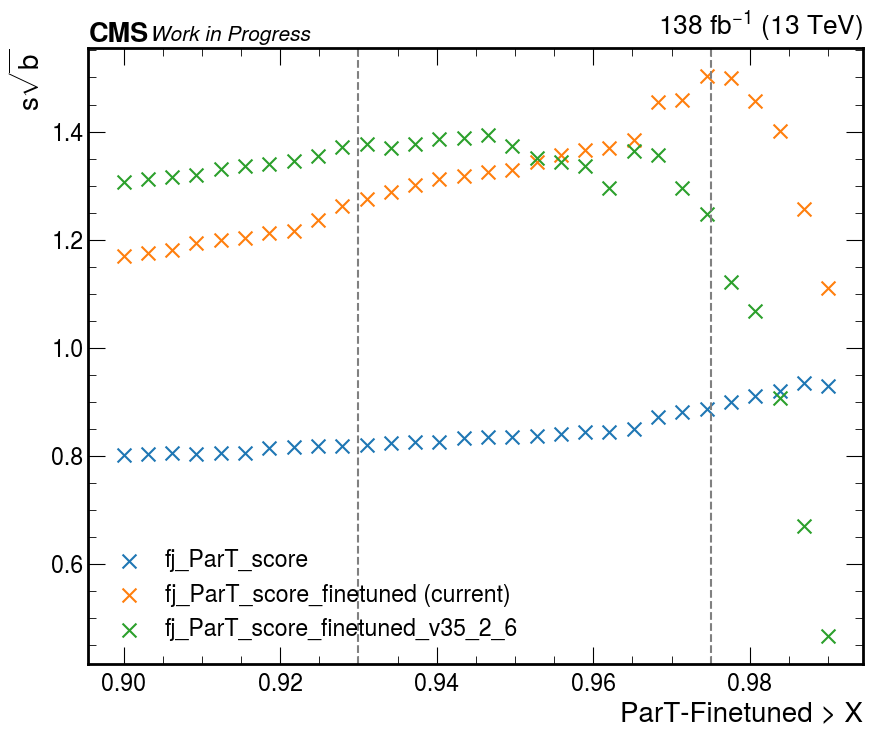

In [111]:
plt.rcParams.update({"font.size": 20})

channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(10, 8))

taggers_to_plot = [
    "fj_ParT_score",
    "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_v35_1",
    "fj_ParT_score_finetuned_v35_2_6",
#     "fj_ParT_score_finetuned_v35_3",
#     "fj_ParT_score_finetuned_v35_4",
#     "fj_ParT_score_finetuned_v35_5",   
]
taggers_to_plot = taggerss

for tagger in taggers_to_plot:   
    if tagger == "fj_ParT_score_finetuned":
        lab = "fj_ParT_score_finetuned (current)"
    elif tagger == "fj_ParT_score_finetuned_v35_1_2":
        lab = "fj_ParT_score_finetuned (new)"
    else:
        lab = tagger
    
    ax.scatter(tagger_cuts, s_over_b[tagger], marker="x", s=100, label=lab)

ax.legend(loc="lower left")
ax.set_ylabel(r"$s\sqrt{b}$")
ax.set_xlabel("ParT-Finetuned > X")

ax.axvline(0.975, linestyle="--", color="grey")
ax.axvline(0.93, linestyle="--", color="grey")

# ax.set_xticks(tagger_cuts)
hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/soverb-new.pdf")

In [57]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = 0

In [112]:
vars_to_plot = [
#     "fj_msoftdrop",        
#     "rec_W_lnu_m",
#     "fj_pt",
#     "lep_pt",
#     "lep_eta",
    
#     "lep_fj_dr",
#     "lep_met_mt",
#     "met_fj_dphi",
#     "met_pt",    
    
#     "btag_1a",
#     "0btag_1b",
#     "1pbtag_1b",
    
#     "0btagT_btagSF",
#     "1plusbtagT_btagSF"
    
#     "rec_higgs_etajet_m",
#     "fj_ParT_mass",
#     "fj_ParT_score_finetuned"
    
    "rec_higgs_m",    
    # AN
#     "FirstFatjet_pt",
#     "SecondFatjet_pt",
#     "fj_pt",
#     "lep_pt",
#     "NumFatjets",
#     "NumOtherJets",
#     "lep_fj_dr",
#     "met_pt",
#     "met_fj_dphi",
#     "lep_met_mt",    
#     "ht",
#     "fj_mass",
#     "rec_W_qq_m",
#     "rec_W_lnu_m",    
#     "fj_lsf3",
    
#     "lep_isolation",
#     "lep_isolation_ele",
#     "lep_isolation_ele_highpt",
#     "lep_isolation_ele_lowpt",
    
#     "lep_isolation_mu",
#     "lep_isolation_mu_highpt",
#     "lep_isolation_mu_lowpt",   
    
#     "lep_misolation",
#     "lep_misolation_highpt",
#     "lep_misolation_lowpt",    
]

samples_to_plot = [
    "ggF", 
    "VBF",
    "ttH",
    "WH",
    "ZH",    
    "QCD",
    "DYJets",
    "WJetsLNu",
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    "Data",
]

# samples_to_plot = ["QCD"]

In [126]:
# tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
tagger = "fj_ParT_score_finetuned_v35_2_6"

tagger_cut = 0.95
# tagger_cut = 0.9
presel = {
#     "Pre-selection": f"fj_pt>0",   # dummy
#     "SR": f"({tagger}>{tagger_cut}) & (n_bjets_T==0)",   # dummy
    
    "SR": f"{tagger}>0.95",
    
#     "Pre-selection": f"(fj_ParT_score_finetuned>0.95) & (fj_msoftdrop>10)",   # dummy    
    
#     "Pre-selection": f"met_pt>100 & ({tagger}<0.5) & n_bjets_T>0",   # dummy    
#     "Pre-selection": f"met_pt>100 & n_bjets_T>0",   # dummy    

#     "Pre-selection": f"met_pt>100 & n_bjets_L==0 & {tagger}>0.5 & {tagger}<0.97",   # dummy    
    
#     "Pre-selection": f"met_pt>20",

#     "SR": f"({tagger}>0.98) & (n_bjets_T==0)",    
    
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & (met_pt>100)",
#     "Top CR": f"({tagger}>0.5) & (n_bjets_T>0)",
}

categories_sel = {
    "VBF": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     rf"ggF": "(mjj<1000) | (deta<3.5)",
        
#     r"ggF pT [250, 300]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300) )",
#     f"ggF pT [300, 450]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450) )",
#     r"ggF pT [450, Inf]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450) )",
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2016APV"]

num, den = 0, 0
threshold = 0

# fill histograms
hists = {}

# ev = events_dict["new_correctionsNOTAGGER"]

ev = events_dict
# ev = events_dict["wjetsNLO"]

# ev = events_dict["new_correctionsNODPHI"]

MET_cut = False
import utilsAN

massbin = 10
for var in vars_to_plot:

    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
        )    
    elif var == "fj_ParT_mass":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"ParT regressed mass [GeV]", overflow=True)
        )              
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utilsAN.axis_dict[var],
#             hist2.axis.Regular(50, 0, 1, name="var", label=r"tagger", overflow=True)
            
        )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                region, sel = list(presel.items())[0]
                
                if sample == "DYJets":
                    continue  
                if sample == "WJetsLNu":
                    df = ev[year][ch][sample]
                    df = pd.concat([df, ev[year][ch]["DYJets"]])
                else:
                    df = ev[year][ch][sample]


#                 if "WJetsLNu" in sample:
#                     df = ev[year][ch]["WJetsLNu"]
                    
#                     if "unmatched" in sample:
#                         df = df[df["fj_V_isMatched"]!=1]
#                     else:
#                         df = df[df["fj_V_isMatched"]==1]
                
#                 else:
#                     df = ev[year][ch][sample]
        
#                 df = ev[year][ch][sample]
                
                df = df.query(sel)
                    
                if "MET>X" in region:
                    MET_cut = 100
                    df = df[df["met_pt"]>MET_cut]
                                
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            
                if sample == "QCD":
                    threshold = 30
                    den += len(df['event_weight'])
                    num += sum(df["event_weight"]>threshold)

                    df = df[df["event_weight"] < threshold]
                
                
                if "lep_isolation_ele" in var:
                    if ch=="ele":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>120)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<120)]                            

                        x = df["lep_isolation"]
                    else:
                        continue
                        
                elif "lep_isolation_mu" in var:
                    if ch=="mu":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                        x = df["lep_isolation"]

                    else:
                        continue
                    
                elif "lep_misolation" in var:
                    if ch == "mu":
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                        x = df["lep_misolation"]
                        
                    else:
                        continue

                else:
                    x = df[var]
                    
#                 if var == "lep_eta":
#                     x = np.absolute(df[var])
                
#                 df = df[np.absolute(df["lep_eta"])<0.5]
#                 x = df[var]
                
                w = df["event_weight"]
                
#                 if sample != "Data":
# #                     w *= df["btag_1a"]
#                     w *= df["0btag_1b"]
# #                     w *= df["1pbtag_1b"]

                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1
    
for var in vars_to_plot:
    fix_neg_yields(hists[var])

ttH, has 1 bins with negative yield.. will set them to 0
ZH, has 1 bins with negative yield.. will set them to 0


Will plot rec_higgs_m histogram
SR (RUN2):
Category: VBF
------------------------
s/sqrt(b) in [100,150]: 1.19
------------------------
Signal: 10.64
- ggF: 21%
- VBF: 79%
------------------------
Background: 68.19
- QCD: 0%
- DYJets: 6%
- Others: 19%
- TTbar: 26%
- WJetsLNu: 49%


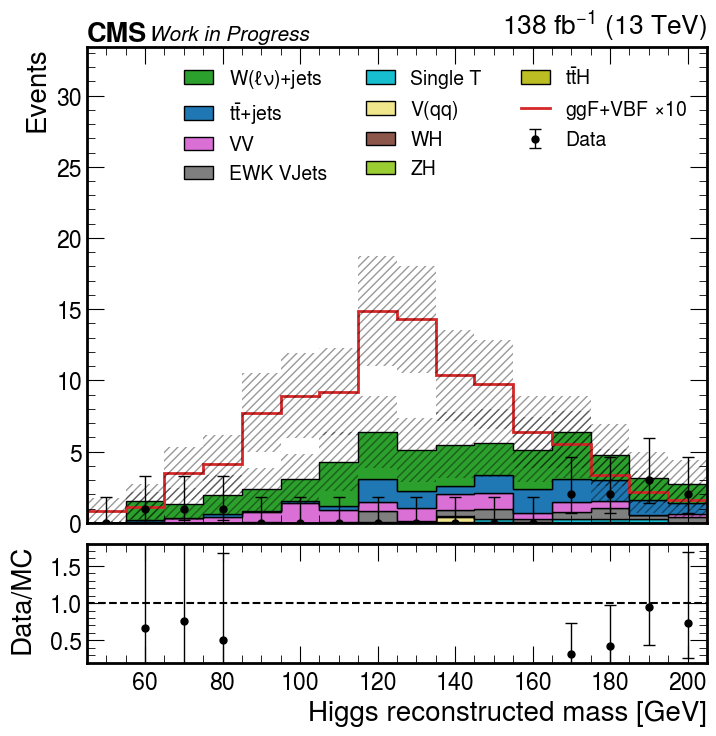

In [127]:
plt.rcParams.update({"font.size": 20})
add_data = True

if "SR" in region or ("Signal region") in region:
    add_soverb=True
    blind_region=[90,160]
    if "SR1" in region:
        mult=10
    else:
        mult=10
else:
    add_soverb=True
    blind_region=[90,160]
    mult=10
    
    
from utils import plot_hists
if len(years) > 1:
    from utilsF import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2/"
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/SignalRegion/"

#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_Run2/"
else:
    from utilsAN import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_{years[0]}/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_{years[0]}/"

PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/"
# from utilsF import plot_hists

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

plot_hists(hists, years, channels, vars_to_plot,             
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=PATH,
            text_=region,
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",

            blind_region=blind_region,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
          )
# print()
get_soverb(ev, tagger, presel, categories_sel, years, channels, threshold=threshold, MET_cut=MET_cut)

In [62]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]
def get_soverb(ev, tagger, presel, categories_sel, years, channels, MET_cut=False, misocut=None, threshold=None):

    mass_window = [100, 150]

    num_sig = {
        "ggF": 0, 
#         "ttH": 0, 
#         "VH": 0,
        "VBF": 0,
    }
    num_bkg = {
        "WJetsLNu": 0, 
        "TTbar": 0, 
        "QCD": 0,
        "DYJets": 0,
        "Others": 0,
    }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0

    samples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "QCD",
        "DYJets",
        "WJetsLNu",
        "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data"
    ]

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                region, sel = list(presel.items())[0]

                df = ev[year][ch][sample]

                df = df.query(sel)  

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)

                if MET_cut:
                    df = df[df["met_pt"]>MET_cut]
                    
                if threshold:
                    if sample == "QCD":
                        df = df[df["event_weight"] < threshold]
    
                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["event_weight"].sum()
                else:
                    b += df["event_weight"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", list(categories_sel.keys())[0])

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
        else:
            print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")             